# Performance comparision between FastAssert and the OpenAI API

In this notebook, we are going to quantify the gains in term of latency of using FastAssert to generate structured JSON outputs comapred to OpenAI function calling. We will also check that we keep the same level of quality in term of JSON structure and JSON content.

Cost are not covered as they depend on the setup to run FastAssert, but one can agree running FastAssert is cheaper than the OpenAI API by several orders of magnitude

For the purpose of this demonstration, we will use OpenAI's own [function calling example](https://platform.openai.com/docs/api-reference/chat/create) (select `Function`on the right) : Text a user prompt asking for the current weather in a city, respond with a structured output containing the name of the city, and the guessed temperature unit in this zone.

In [96]:
# The structure we are expecting
json_obj = {
  "type": "object",
  "properties": {
    "location": {
      "type": "string",
      "description": "The city and state, e.g., San Francisco, CA"
    },
    "unit": {
      "type": "string",
      "enum": ["celsius", "fahrenheit"],
      "description": "The temperature unit"
    }
  },
  "required": ["location", "unit"],
  "additionalProperties": False
}

# A list of inputs to test the project, that will be formated in text prompts before being passed to the constrained LLMs
# For notebook visibility purposes, we put them in a compact format
inputs = [{"location": "Paris", "unit": "celsius"},{"location": "Toronto", "unit": "fahrenheit"}, {"location": "Sydney", "unit": "celsius"}, {"location": "Berlin", "unit": "celsius"}, {"location": "Moscow", "unit": "celsius"}, {"location": "Mumbai", "unit": "celsius"}, {"location": "New York, NY", "unit": "fahrenheit"}, {"location": "London", "unit": "celsius"}, {"location": "Tokyo", "unit": "celsius"}, {"location": "Cairo", "unit": "celsius"}, {"location": "Los Angeles", "unit": "fahrenheit"}, {"location": "Beijing", "unit": "celsius"}, {"location": "Cape Town", "unit": "celsius"}, {"location": "Mexico City", "unit": "celsius"}]
print(f"This demo will be runned on {len(inputs)} examples")

# Build the prompts using these inputs
# Prepare one example for the model
example = "For example, a valid response is " + '{\\"location\\": \\"Paris\\",\\"unit\\":\\"celsius\\"}.'
prompts = []
for input in inputs:
    prompts.append(f"What's the weather like in {input.get('location')} today? Temperature unit can only be celsius or fahrenheit. " + example + " Respond with the city name and the temperature unit used in this zone in this format.")

print(f"Prompts are variations of this one: {prompts[0]}")

This demo will be runned on 14 examples
Prompts are variations of this one: What's the weather like in Paris today? Temperature unit can only be celsius or fahrenheit. For example, a valid response is {\"location\": \"Paris\",\"unit\":\"celsius\"}. Respond with the city name and the temperature unit used in this zone in this format.


## Installation and Setup

Make sure you are using the right kernel (`notebookenv`)

In [2]:
!pip install requests openai

In [25]:
import os

# Setup the OpenAI client
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Create the function to generate structured output using OpenAI
def openai_constrained_generation(prompt: str, json_schema, model_name="gpt-3.5-turbo"):

    tools = [
      {
        "type": "function",
        "function": {
          "name": "get_current_weather",
          "description": "Get the current weather in a given location",
          "parameters": json_obj,
        }
      }
    ]
    messages = [{"role": "user", "content": prompt}]
    completion = client.chat.completions.create(
      model=model_name,
      messages=messages,
      tools=tools,
      tool_choice={"type": "function", "function": {"name": "get_current_weather"}},
      temperature=0
    )

    return completion.choices[0].message.tool_calls[0].function.arguments

In [63]:
# Let's try it out
openai_constrained_generation("What's the weather like in Boston today? Respond with the city name and the temperature unit used in this zone. Temperature unit can only be celsius or fahrenheit." + example, json_obj)


'{\n  "location": "Boston, MA",\n  "unit": "celsius"\n}'

## Connect and test our FastAssert server
Make sure the docker container is running and can serve requests.

In [64]:
import requests
import time

BASE_URL = "http://127.0.0.1:8000"

# Ping the server
ping_response = requests.get(f"{BASE_URL}/health")

# Check if the request was successful
if ping_response.status_code == 200:
    print("Server is up and running!")
else:
    raise ValueError(f"Failed to reach the server, status code: {ping_response.status_code}")

Server is up and running!


In [55]:
import json
# Create the json LLM generation
def constrained_generation(prompt: str, json_schema):

    url = f"{BASE_URL}/generate"
    payload = {
        "prompt": prompt,
        "schema": json_schema,
        "temperature": 0
    }

    response = requests.post(url, json=payload)
    parsed_response = json.loads(response.text)

    prompt_and_llm_answer = parsed_response['text'][0]

    # Remove the input text, as it is returned completed with the answer
    llm_answer = prompt_and_llm_answer[len(prompt):]

    return llm_answer

In [57]:
# Let's try our FastAssert server
constrained_generation("What's the weather like in Boston today? Respond with the city name and the temperature unit used in this zone. Temperature unit can only be celsius or fahrenheit." + instruction, json_obj)


'{"location": "Boston","unit":"fahrenheit"}'

## Let's benchmark the two methods

We will run on the input list 3 constrained generation models :
- OpenAI `gpt-3.5-turbo` with function call
- OpenAI `gpt-4` with function call
- our FastAssert server running a constrained `Mistral-7B-v0.2`

### Running the models

In [99]:
openai_gpt3_5_times = []
openai_gpt4_times = []
fastassert_times = []

openai_gpt3_5_answers = []
openai_gpt4_answers = []
fastassert_answers = []

# We use the exact same prompt for each model
for prompt in prompts:
    # Time OpenAI gpt-3.5-turbo
    start_time = time.time()
    answer = openai_constrained_generation(prompt, json_obj)
    end_time = time.time()
    openai_gpt3_5_answers.append(answer)
    openai_gpt3_5_times.append(end_time - start_time)

    # Time OpenAI gpt-4
    start_time = time.time()
    answer = openai_constrained_generation(prompt, json_obj, model_name="gpt-4")
    end_time = time.time()
    openai_gpt4_answers.append(answer)
    openai_gpt4_times.append(end_time - start_time)

    # Time FastAssert
    start_time = time.time()
    answer = constrained_generation(prompt + instruction, json_obj)
    end_time = time.time()
    fastassert_answers.append(answer)
    fastassert_times.append(end_time - start_time)

In [97]:
## DEBUG

fastassert_times = []

fastassert_answers = []

# We use the exact same prompt for each model
for prompt in prompts:

    # Time FastAssert
    start_time = time.time()
    answer = constrained_generation(prompt + instruction, json_obj)
    end_time = time.time()
    fastassert_answers.append(answer)
    fastassert_times.append(end_time - start_time)

### Assessing the results

#### Latency

In [20]:
!pip install matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 103.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 130.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 117.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 21.2 MB/s eta 0:00:00


In [100]:
import statistics

# Assuming inputs are defined and the above loop code has been executed

# Calculate mean and standard deviation for OpenAI GPT-3.5 times
mean_gpt3_5 = statistics.mean(openai_gpt3_5_times)
std_dev_gpt3_5 = statistics.stdev(openai_gpt3_5_times)

# Calculate mean and standard deviation for OpenAI GPT-4 times
mean_gpt4 = statistics.mean(openai_gpt4_times)
std_dev_gpt4 = statistics.stdev(openai_gpt4_times)

# Calculate mean and standard deviation for FastAssert times
mean_fastassert = statistics.mean(fastassert_times)
std_dev_fastassert = statistics.stdev(fastassert_times)

# Print the results
print("Completion times:")
print(f"OpenAI GPT-3.5 Mean: {mean_gpt3_5} s, Standard Deviation: {std_dev_gpt3_5}")
print(f"OpenAI GPT-4 Mean: {mean_gpt4} s, Standard Deviation: {std_dev_gpt4}")
print(f"FastAssert Mean: {mean_fastassert} s, Standard Deviation: {std_dev_fastassert}")

Completion times:
OpenAI GPT-3.5 Mean: 0.8534583875111171 s, Standard Deviation: 0.18086406864731974
OpenAI GPT-4 Mean: 1.1603457927703857 s, Standard Deviation: 0.2482123538585998
FastAssert Mean: 0.2983722516468593 s, Standard Deviation: 0.01182277109689749


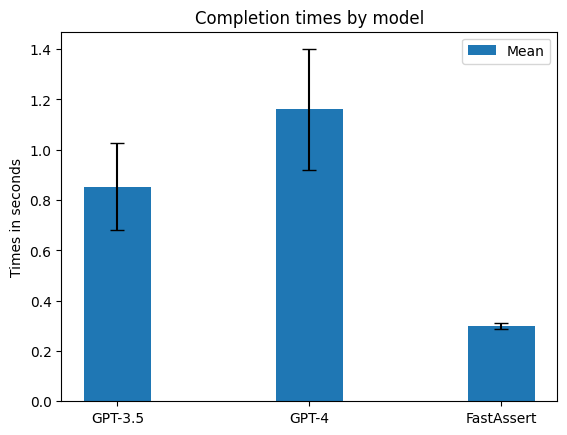

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['GPT-3.5', 'GPT-4', 'FastAssert']
means = [np.mean(openai_gpt3_5_times), np.mean(openai_gpt4_times), np.mean(fastassert_times)]
std_devs = [np.std(openai_gpt3_5_times), np.std(openai_gpt4_times), np.std(fastassert_times)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, means, width, label='Mean', yerr=std_devs, capsize=5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Times in seconds')
ax.set_title('Completion times by model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### Validation errors

In [102]:
import json
from jsonschema import validate, ValidationError

def validate_openai_json(text, schema):
    # Step 1: Unescape the string
    # Decode the escaped string to get the actual JSON string
    json_string = text.replace(r'\n', '')
    
    # Step 2: Parse the JSON string into a Python dictionary
    json_obj = json.loads(json_string)

    # Step 3: Validate the JSON object against the schema
    try:
        validate(instance=json_obj, schema=schema)
        return True
    except ValidationError as e:
        return False
    
def validate_fastassert_json(text, schema):
    try:
        # Load the JSON
        json_obj = json.loads(text)
        # Validate the JSON object against the schema
        validate(instance=json_obj, schema=schema)
        return True
    except Exception as e:
        return False


In [104]:
openai_gpt3_5_validations = []
openai_gpt4_validations = []
fastassert_validations = []

for answer in openai_gpt3_5_answers:
    if validate_openai_json(answer, json_obj):
        openai_gpt3_5_validations.append(1)
    else:
        openai_gpt3_5_validations.append(0)

for answer in openai_gpt4_answers:
    if validate_openai_json(answer, json_obj):
        openai_gpt4_validations.append(1)
    else:
        openai_gpt4_validations.append(0)

for answer in fastassert_answers:
    if validate_fastassert_json(answer, json_obj):
        fastassert_validations.append(1)
    else:
        fastassert_validations.append(0)

print(f"OpenAI GPT-3.5 validation error rate: {1- sum(openai_gpt3_5_validations)/len(openai_gpt3_5_validations)}")
print(f"OpenAI GPT-4 validation error rate: {1- sum(openai_gpt4_validations)/len(openai_gpt4_validations)}")
print(f"Fastassert validation error rate: {1- sum(fastassert_validations)/len(fastassert_validations)}")

OpenAI GPT-3.5 validation error rate: 0.0
OpenAI GPT-4 validation error rate: 0.0
Fastassert validation error rate: 0.0


### Check the extracted data

The hardest part of the task is infering the commonly used temperature unit. We will check the success accuracy of the several models on this task

In [131]:
def compute_accuracy(inputs, answers):

    results = []

    for i in range(0, len(inputs)):
        input = inputs[i]
        answer = answers[i]

        answer = answer.replace(r'\n', '')

        #try:
        # Load the json object
        json_obj = json.loads(answer)

        # Check the "unit" key against the input label
        if input["unit"] == json_obj["unit"]:
            results.append(1)
        else:
            results.append(0)
        #except Exception as e:
        #    results.append(0)

    return sum(results)/len(results)

In [133]:
compute_accuracy(inputs, fastassert_answers)

print(f"GPT3-5 turbo accuracy {compute_accuracy(inputs, openai_gpt3_5_answers)}")
print(f"GPT4 accuracy {compute_accuracy(inputs, openai_gpt4_answers)}")
print(f"FastAssert accuracy {compute_accuracy(inputs, fastassert_answers)}")
print("")

if compute_accuracy(inputs, openai_gpt3_5_answers) <= compute_accuracy(inputs, fastassert_answers):
    print("FastAssert achieved the same accuracy as GPT3-5 turbo on this extraction task!")

GPT3-5 turbo accuracy 0.7857142857142857
GPT4 accuracy 0.9285714285714286
FastAssert accuracy 0.7857142857142857

FastAssert achieved the same accuracy as GPT3-5 turbo on this extraction task!
